<a href="https://colab.research.google.com/github/Azimoj/Home-Credit-Default-Risk/blob/main/Dashboard_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
! pip install jyquickhelper

In [ ]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [ ]:
! pip install shap

In [76]:
# Chargement des librairies
import datetime
#import sys
import time
from datetime import datetime
import warnings
#import jyquickhelper
import numpy as np
import pandas as pd
import pickle
#from joblib import dump, load
#from collections import Counter


# Visualisation
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.lines as mlines
import seaborn as sns
import plotly.graph_objects as go

# Modèle
import sklearn
#from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
# Standardisation
from sklearn.preprocessing import StandardScaler

# Interprétation
import shap
# Warnings
import warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
# Chargement à chaud des librairies personnelles
%load_ext autoreload
%autoreload 2
# Valide code pep

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

In [53]:
def reduce_mem_usage(data, verbose=True):
    # source: https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
    '''
    This function is used to reduce the memory usage by converting the datatypes of a pandas
    DataFrame withing required limits.
    '''

    start_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('-' * 79)
        print('Memory usage du dataframe: {:.2f} MB'.format(start_mem))

    for col in data.columns:
        col_type = data[col].dtype

        #  Float et int
        if col_type != object:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(
                        np.int8).min and c_max < np.iinfo(
                        np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)
            else:
                if c_min > np.finfo(
                        np.float16).min and c_max < np.finfo(
                        np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)

        # # Boolean : pas à faire car pour machine learning il faut des int 0/1
        # et pas False/True
        # if list(data[col].unique()) == [0, 1] or list(data[col].unique()) == [1, 0]:
        #     data[col] = data[col].astype(bool)

    end_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage après optimization: {:.2f} MB'.format(end_mem))
        print('Diminution de {:.1f}%'.format(
            100 * (start_mem - end_mem) / start_mem))
        print('-' * 79)

    return data

In [7]:
# Original Dataset 
#application_train = pd.read_csv('/content/drive/MyDrive/p7/data/application_train.csv')
application_test = pd.read_csv('/content/drive/MyDrive/p7/data/application_test.csv')

In [ ]:
application_train.shape, application_test.shape

((307511, 122), (48744, 121))

In [8]:
# dataset after preprocesing

train_set = pd.read_csv('/content/drive/MyDrive/p7/data/data_train.csv')
test_set = pd.read_csv('/content/drive/MyDrive/p7/data/data_test.csv')

In [ ]:
test_set.shape

(48744, 896)

In [ ]:
# Train dataset split
#X_train_fin = pd.read_csv('/content/drive/MyDrive/p7/data/X_train_fin.csv')
#X_test_fin = pd.read_csv('/content/drive/MyDrive/p7/data/X_test_fin.csv')

In [ ]:
#X_train_fin.shape

(246005, 896)

In [9]:
import pickle
best_model = pickle.load(open('/content/drive/MyDrive/p7/best_model.sav', 'rb'))
best_model

LGBMClassifier(boosting_type='goss', class_weight='balanced',
               colsample_bytree=0.78, force_col_wise=True, max_depth=10,
               min_child_samples=54, min_child_weight=42, min_split_gain=0.015,
               num_leaves=35, objective='binary', reg_alpha=0.28,
               reg_lambda=0.03, seed=0, subsample=0.2)

## Scoring (prédictions/Probabilités)

In [10]:
# Copie du jeu de test
test = test_set.copy(deep=True)
# Sauvegarde des identifiants des clients inutiles aux prédictions
id_client = test['SK_ID_CURR']
# Préparation de la matrice à soumettre aux prédictions 
X_test = test.drop('SK_ID_CURR', axis=1)

In [ ]:
X_test.shape

(48744, 895)

In [11]:
# Score des prédictions de probabiltés
y_proba = best_model.predict_proba(X_test)[:, 1]

In [12]:
# Score des prédictions de probabiltés
y_proba = best_model.predict_proba(X_test)[:, 1]

In [13]:
# Prédictions pour le client :
# classe 0 : non défaillant, classe 1 : défaillant
y_pred = best_model.predict(X_test)

In [14]:
# Constitution du dataframe pour merge
df_score = pd.DataFrame({'SK_ID_CURR' : id_client,
                         'PRED_CLASSE_CLIENT' : y_pred,
                         'SCORE_CLIENT' : y_proba,
                         'SCORE_CLIENT_%' : np.round(y_proba * 100, 1)})
df_score.head(3)

,SK_ID_CURR,PRED_CLASSE_CLIENT,SCORE_CLIENT,SCORE_CLIENT_%
0,100001,0,0.346507,34.7
1,100005,0,0.381842,38.2
2,100013,0,0.108651,10.9


In [15]:
# Ajout des prédictions au dataframe du jeu de test
df_dashboard = df_score.merge(test_set, on='SK_ID_CURR', how='left')
df_dashboard.head(3)

,SK_ID_CURR,PRED_CLASSE_CLIENT,SCORE_CLIENT,SCORE_CLIENT_%,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_NEW_INSTALLMENTS_PER_LOAN_MIN,CC_NEW_INSTALLMENTS_PER_LOAN_MAX,CC_NEW_INSTALLMENTS_PER_LOAN_MEAN,CC_NEW_INSTALLMENTS_PER_LOAN_SUM,CC_NEW_INSTALLMENTS_PER_LOAN_VAR,CC_COUNT
0,100001,0,0.346507,34.7,0,0,0,0,135000.0,568800.0,...,0.0,0.0,0.0,0.0,27.0,27.0,27.0,810.0,0.0,30.0
1,100005,0,0.381842,38.2,1,0,0,0,99000.0,222768.0,...,0.0,0.0,0.0,0.0,5.0,5.0,5.0,35.0,0.0,7.0
2,100013,0,0.108651,10.9,1,1,0,0,202500.0,663264.0,...,0.0,0.0,0.0,0.0,25.0,25.0,25.0,2075.0,0.0,83.0


In [ ]:
df_dashboard.shape

(48744, 899)

In [16]:
# Sauvegarde de df_dashboard
fic_sav_df_dashboard ='/content/drive/MyDrive/p7/dashboard/df_dashboard_1.pickle'
with open(fic_sav_df_dashboard, 'wb') as f:
    pickle.dump(df_dashboard, f, pickle.HIGHEST_PROTOCOL)

In [41]:
# Chargement du dataframe df_dashboard_1
fic_sav_df_dashboard_1 ='/content/drive/MyDrive/p7/dashboard/df_dashboard_1.pickle'
with open(fic_sav_df_dashboard_1, 'rb') as df_dashboard_1:
    df_dashboard = pickle.load(df_dashboard_1)
df_dashboard.shape

(48744, 899)

4. **Préparation des données informatives**

Customer Information

Informative data on the customer to be made available and readable for the account manager:

In [18]:
df_infos =application_test[['SK_ID_CURR',
                           'AMT_INCOME_TOTAL', 'NAME_FAMILY_STATUS',
                            'AMT_GOODS_PRICE', 'CNT_CHILDREN',
                            'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE',
                            'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE']]
df_infos.head(3)

,SK_ID_CURR,AMT_INCOME_TOTAL,NAME_FAMILY_STATUS,AMT_GOODS_PRICE,CNT_CHILDREN,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,NAME_INCOME_TYPE
0,100001,135000.0,Married,450000.0,0,Cash loans,Higher education,House / apartment,Working
1,100005,99000.0,Married,180000.0,0,Cash loans,Secondary / secondary special,House / apartment,Working
2,100013,202500.0,Married,630000.0,0,Cash loans,Higher education,House / apartment,Working


In [ ]:
df_infos.shape

(48744, 9)

In [42]:
# Ajout des varaibles manquantes au dataframe du dashboard
pd.set_option('display.max_columns', None)
df_dashboard = df_dashboard.merge(df_infos, on='SK_ID_CURR',how='inner', suffixes=('', '_remove'))
df_dashboard.head(3)

,SK_ID_CURR,PRED_CLASSE_CLIENT,SCORE_CLIENT,SCORE_CLIENT_%,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,WEEKDAY_APPR_PROCESS_START_SIN,WEEKDAY_APPR_PROCESS_START_COS,HOUR_APPR_PROCESS_START_SIN,HOUR_APPR_PROCESS_START_COS,NEW_DAYS_EMPLOYED_PERC,NEW_INCOME_CREDIT_PERC,NEW_INCOME_PER_PERSON,NEW_ANNUITY_INCOME_PERC,NEW_ANNUITY_CREDIT_RATIO,NEW_EXT_MEAN,NEW_EXT_PROD,NEW_AGE,NEW_ACCOMPANIED,NEW_DEF_30&60_SOCIAL_CIRCLE,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_nan,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_nan,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_EDUCATION_TYPE_nan,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_FAMILY_STATUS_nan,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_HOUSING_TYPE_nan,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,OCCUPATION_TYPE_nan,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION

In [43]:
df_dashboard['YEAR_BIRTH']= np.trunc(np.abs(df_dashboard['DAYS_BIRTH'] / 365)).astype('int8')

In [44]:
df_dashboard.shape

(48744, 908)

In [45]:
# Transformer DAYS_EMPLOYED en années positives
df_dashboard['YEAR_EMPLOYED'] = np.abs(df_dashboard['DAYS_EMPLOYED'] / 365)
 

In [46]:
# Transformer sexe : 0 = Féminin et 1 = Masculin
df_dashboard['SEXE'] = ['Féminin' if row == 0 else 'Masculin'
                        for row in df_dashboard['CODE_GENDER']] 

In [47]:
# Sauvegarde de df_dashboard_2
fic_sav_df_dashboard ='/content/drive/MyDrive/p7/dashboard/df_dashboard_2.pickle'
with open(fic_sav_df_dashboard, 'wb') as f:
    pickle.dump(df_dashboard, f, pickle.HIGHEST_PROTOCOL)

In [48]:
# Chargement du dataframe df_dashboard_2
fic_sav_df_dashboard_2 ='/content/drive/MyDrive/p7/dashboard/df_dashboard_2.pickle'
with open(fic_sav_df_dashboard_2, 'rb') as df_dashboard_2:
    df_dashboard = pickle.load(df_dashboard_2)
df_dashboard.shape

(48744, 910)

**4.2. Variables ayant le plus d'importance sur le modèle**

Les variables ayant le plus d'importance sur le modèle constituent les variables à comparer pour situer notre client par rapport à la moyenne des valeurs de ces variables pour tous les clients et comparer ces valeurs avec celles des 10 plus proches voisins qui ont des valeurs similaires à notre client.
Le but est de tracer un lineplot pour chacune de ces variables déterminantes pour comparer les valeurs du client, les valeurs moyennes sur l'ensemble des clients et les valeurs des 10 plus proches voisins séparés en 2 groupes : défaillant et non-défaillant.
**Variables à comparer ?**

**Features importances**

D'après le notebook sur la modélisation, les 10 variables issus de l'analyse des features importances ayant le plus d'impact sur le meilleur modèle sont :

[X] CREDIT_ANNUITY RATIO

[x] EXT_SOURCE_SUM

[X] INST_PAY_DAYS_PAYMENT_RATIO_MAX

[X] PREV_APP_INTEREST_SHARE_MAX

[X] EXT_SOURCE_1

[X] CREDIT_GOODS_RATIO

[X] CODE GENDER

[X] INST_PAY_AMT_INSTALMENT_SUM

[X] EXT_SOURCE_2

[X] DAYS_BIRTH

[X] AMT_ANNUITY

[X] BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN

**Shapley values globales**

In [28]:
feature_importances = pickle.load( open('drive/MyDrive/p7/feature_importances.sav', 'rb'))
fi= feature_importances.head(20)
fi.feature

94                 NEW_ANNUITY_CREDIT_RATIO
29                             EXT_SOURCE_3
95                             NEW_EXT_MEAN
28                             EXT_SOURCE_2
27                             EXT_SOURCE_1
12                              OWN_CAR_AGE
6                               AMT_ANNUITY
9                             DAYS_EMPLOYED
8                                DAYS_BIRTH
90                   NEW_DAYS_EMPLOYED_PERC
5                                AMT_CREDIT
96                             NEW_EXT_PROD
97                                  NEW_AGE
11                          DAYS_ID_PUBLISH
0                               CODE_GENDER
10                        DAYS_REGISTRATION
59                   DAYS_LAST_PHONE_CHANGE
117    NAME_EDUCATION_TYPE_Higher education
100           NAME_CONTRACT_TYPE_Cash loans
93                  NEW_ANNUITY_INCOME_PERC
Name: feature, dtype: object

In [29]:
pd.set_option('display.max_rows', None)
 
# storing the dataset as data frame
dataframe = pd.DataFrame(fi.feature, columns = fi.feature)
 
# printing data frame
print(dataframe)

Empty DataFrame
Columns: [NEW_ANNUITY_CREDIT_RATIO, EXT_SOURCE_3, NEW_EXT_MEAN, EXT_SOURCE_2, EXT_SOURCE_1, OWN_CAR_AGE, AMT_ANNUITY, DAYS_EMPLOYED, DAYS_BIRTH, NEW_DAYS_EMPLOYED_PERC, AMT_CREDIT, NEW_EXT_PROD, NEW_AGE, DAYS_ID_PUBLISH, CODE_GENDER, DAYS_REGISTRATION, DAYS_LAST_PHONE_CHANGE, NAME_EDUCATION_TYPE_Higher education, NAME_CONTRACT_TYPE_Cash loans, NEW_ANNUITY_INCOME_PERC]
Index: []


In [28]:
# Liste des variables les plus déterminantes
feat_imp = ['NEW_ANNUITY_CREDIT_RATIO', 
            'EXT_SOURCE_3', 
            'NEW_EXT_MEAN', 
            'EXT_SOURCE_2', 
            'EXT_SOURCE_1', 
            'OWN_CAR_AGE', 
            'AMT_ANNUITY', 
            'DAYS_EMPLOYED', 
            'DAYS_BIRTH', 
            'NEW_DAYS_EMPLOYED_PERC', 
            'AMT_CREDIT', 
            'NEW_EXT_PROD', 
            'NEW_AGE', 
            'DAYS_ID_PUBLISH', 
            'CODE_GENDER', 
            'DAYS_REGISTRATION', 
            'DAYS_LAST_PHONE_CHANGE',
            'NAME_EDUCATION_TYPE_Higher education', 
            'NAME_CONTRACT_TYPE_Cash loans', 
            'NEW_ANNUITY_INCOME_PERC']


**AMT_ANNUITY**

Annuité de prêt

**BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN**

Valeur minimale de la différence entre la limite de crédit actuelle de la carte de crédit et la dette actuelle sur le crédit

**BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN**

Valeur moyenne de la différence entre la limite de crédit actuelle de la carte de crédit et la dette actuelle sur le crédit

**BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN**

Moyenne du ratio des prêts précédents sur d'autres institution de : la dette actuelle sur le crédit et la limite de crédit actuelle de la carte de crédit

**CAR_EMPLOYED_RATIO**

Ratio : Âge de la voiture du demandeur / Ancienneté dans l'emploi à la date de la demande

**CODE_GENDER**

Sexe

**CREDIT_ANNUITY_RATIO**

Ratio : montant du crédit du prêt / Annuité de prêt

**CREDIT_GOODS_RATIO**

Ratio : Montant du crédit du prêt / prix des biens pour lesquels le prêt est accordé / Crédit est supérieur au prix des biens ?

**DAYS_BIRTH**

Âge

**DAYS_ID_PUBLISH**

Combien de jours avant la demande le client a-t-il changé la pièce d'identité avec laquelle il a demandé le prêt ?

**EXT_SOURCE_1**

Source externe normalisée

**EXT_SOURCE_2**

Source externe normalisée

**EXT_SOURCE_3**

Source externe normalisée

In [ ]:
# Matrice X - variables les plus déterminantes
X = train_set[feat_imp]

In [ ]:
"""# Standardisation KNN utilise les distances - train set
scaler_std = StandardScaler()
X_std = scaler_std.fit_transform(X)
X_std = pd.DataFrame(X_std, index=X.index, columns=X.columns.to_list())
X_std.shape"""

(307507, 20)

In [ ]:
# Vecteur y
# y = df_dashboard['SCORE_CLIENT'].astype('int64')
y = train_set['TARGET']
y.shape

(307507,)

In [ ]:
# Matrice X_test - variables les plus déterminantes
X_test = test_set[feat_imp]

In [ ]:
"""# Standardisation KNN utilise les distances - test set
scaler_std = StandardScaler()
X_test_std = scaler_std.fit_transform(X_test)
X_test_std = pd.DataFrame(X_test_std, index=X_test.index,
                          columns=X_test.columns.to_list())
X_test_std.shape"""

(48744, 20)

In [ ]:
# Vecteur y
y_test = df_dashboard['SCORE_CLIENT'].astype('int64')
y_test.shape

(48744,)

5. Préparation des graphiques
5.1. Informations générales
**Client courant**
Les données informatives à afficher une fois le client sélectionner :

sur les traits stricts du client :

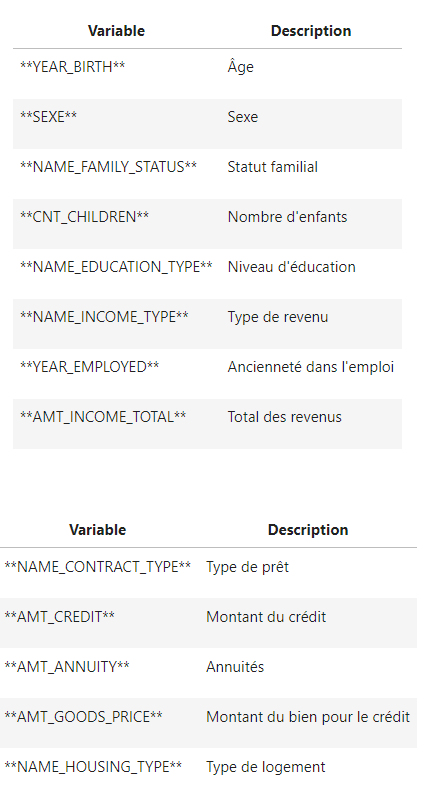

In [49]:
# Traits stricts du client
df_info_client = df_dashboard[['SK_ID_CURR', 'YEAR_BIRTH', 'SEXE',
                               'NAME_FAMILY_STATUS',
                               'CNT_CHILDREN', 'NAME_EDUCATION_TYPE',
                                'YEAR_EMPLOYED',
                               'AMT_INCOME_TOTAL']]

In [51]:
df_info_client = df_info_client.rename(columns = {
     'YEAR_BIRTH' : 'Âge (ans)',
     'SEXE' : 'Sexe',
     'NAME_FAMILY_STATUS' : 'Statut familial',
     'CNT_CHILDREN' : 'Nbre enfants',
     'NAME_EDUCATION_TYPE' : 'Niveau éducation',
     'NAME_INCOME_TYPE' : 'Type revenu',
     'YEAR_EMPLOYED' : 'Ancienneté emploi',
     'AMT_INCOME_TOTAL' : 'Revenus ($)'})
df_info_client.head(3)

,SK_ID_CURR,Âge (ans),Sexe,Statut familial,Nbre enfants,Niveau éducation,Ancienneté emploi,Revenus ($)
0,100001,52,Féminin,Married,0,Higher education,6.380822,135000.0
1,100005,49,Masculin,Married,0,Secondary / secondary special,12.243836,99000.0
2,100013,54,Masculin,Married,0,Higher education,12.213699,202500.0


In [54]:
# Réduction de la taille des variables pour optimisation mémoire
df_info_client = reduce_mem_usage(df_info_client)

-------------------------------------------------------------------------------
Memory usage du dataframe: 3.02 MB
Memory usage après optimization: 2.05 MB
Diminution de 32.3%
-------------------------------------------------------------------------------


In [57]:
# Sauvegarde de df_info_client
fic_sav_df_info_client ='/content/drive/MyDrive/p7/dashboard/df_info_client.pickle'
with open(fic_sav_df_info_client, 'wb') as f:
    pickle.dump(df_info_client, f, pickle.HIGHEST_PROTOCOL)

In [59]:
# Chargement du dataframe df_info_client
fic_sav_df_info_client ='/content/drive/MyDrive/p7/dashboard/df_info_client.pickle'
with open(fic_sav_df_info_client, 'rb') as df_info_client:
    df_info_client = pickle.load(df_info_client)
df_info_client.shape

(48744, 8)

In [63]:
filename = '/content/drive/MyDrive/p7/pickle/df_info_client.pickle'
outfile = open(filename,'wb')
pickle.dump(df_info_client, outfile)
outfile.close()

In [64]:
# Infos principales client
client_id = 100001
client_info = df_info_client[df_info_client['SK_ID_CURR'
                                           ] == client_id].iloc[:, 2:]
client_info.style.hide_index()

Sexe,Statut familial,Nbre enfants,Niveau éducation,Ancienneté emploi,Revenus ($)
Féminin,Married,0,Higher education,6.378906,135000.000000


**Informations sur la demande de prêt du client**

In [65]:
# Informations sur la demande prêt
df_pret_client = df_dashboard[['SK_ID_CURR', 'NAME_CONTRACT_TYPE',
                               'AMT_CREDIT',
                               'AMT_ANNUITY', 'AMT_GOODS_PRICE',
                               'NAME_HOUSING_TYPE']]

In [67]:
df_pret_client = df_pret_client.rename(columns = {
     'NAME_CONTRACT_TYPE' : 'Type de prêt',
     'AMT_CREDIT' : 'Montant du crédit ($)',
     'AMT_ANNUITY' : 'Annuités ($)',
     'AMT_GOODS_PRICE' : 'Montant du bien ($)',
     'NAME_HOUSING_TYPE' : 'Type de logement'})
df_pret_client.head(3)

,SK_ID_CURR,Type de prêt,Montant du crédit ($),Annuités ($),Montant du bien ($),Type de logement
0,100001,Cash loans,568800.0,20560.5,450000.0,House / apartment
1,100005,Cash loans,222768.0,17370.0,180000.0,House / apartment
2,100013,Cash loans,663264.0,69777.0,630000.0,House / apartment


In [69]:
# Réduction de la taille des variables pour optimisation mémoire
df_pret_client = reduce_mem_usage(df_pret_client)

-------------------------------------------------------------------------------
Memory usage du dataframe: 2.60 MB
Memory usage après optimization: 1.86 MB
Diminution de 28.6%
-------------------------------------------------------------------------------


In [70]:
# Sauvegarde de df_pret_client
fic_sav_df_pret_client ='/content/drive/MyDrive/p7/dashboard/df_pret_client.pickle'
with open(fic_sav_df_pret_client, 'wb') as f:
    pickle.dump(df_pret_client, f, pickle.HIGHEST_PROTOCOL)

In [71]:
# Chargement du dataframe df_pret_client
fic_sav_df_pret_client ='/content/drive/MyDrive/p7/dashboard/df_pret_client.pickle'
with open(fic_sav_df_pret_client, 'rb') as df_pret_client:
    df_pret_client = pickle.load(df_pret_client)
df_pret_client.shape

(48744, 6)

In [102]:
filename = '/content/drive/MyDrive/p7/pickle/df_pret_client.pickle'
outfile = open(filename,'wb')
pickle.dump(df_pret_client, outfile)
outfile.close()

In [74]:
# Lineplot de comparaison des features importances client courant/voisins
plt.figure(figsize=(6, 4))
plt.plot(x_gp1, y_feat_client_gp1, color='Orange',
         label='Client courant')
plt.plot(x_gp1, y_moy_feat_voisins_gp3, color='SteelBlue',
         label='Moyenne des Clients voisins')
plt.plot(x_gp1, y_all_train_nondef_gp3, color='Green',
         label='Moyenne des Clients non-défaillants')
plt.plot(x_gp1, y_all_train_def_gp3, color='Crimson',
         label='Moyenne des Clients défaillants')
plt.xticks(rotation=90)
plt.legend(title='Légende :', title_fontsize=16, 
           bbox_to_anchor=(1.05, 1),
           loc=2, borderaxespad=0., fontsize=16)
plt.show()

NameError: ignored

<Figure size 432x288 with 0 Axes>

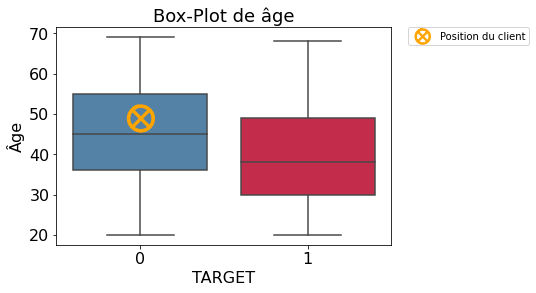

In [73]:
sns.boxplot(x='PRED_CLASSE_CLIENT',
            y='YEAR_BIRTH',
            data=df_dashboard,
            palette=['SteelBlue', 'Crimson'])
plt.title("Box-Plot de âge", fontsize=18)
plt.xlabel('TARGET', fontsize=16)
plt.ylabel('Âge', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

df_client = df_dashboard.iloc[1]
plt.plot(df_client['PRED_CLASSE_CLIENT'],
         df_client['YEAR_BIRTH'],
         color="orange",
         marker="$\\bigotimes$", markersize=28)
import matplotlib.lines as mlines
client = mlines.Line2D([], [], color='orange', marker='$\\bigotimes$',
                       linestyle='None',
                       markersize=16, label='Position du client')
plt.legend(handles=[client],
               bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

5.3. **Score du client**

Prédiction pour un client

In [96]:
# Sélection des variables du clients
client_id = 100001
X_test = test_set[test_set['SK_ID_CURR'] == client_id]
X_test

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,WEEKDAY_APPR_PROCESS_START_SIN,WEEKDAY_APPR_PROCESS_START_COS,HOUR_APPR_PROCESS_START_SIN,HOUR_APPR_PROCESS_START_COS,NEW_DAYS_EMPLOYED_PERC,NEW_INCOME_CREDIT_PERC,NEW_INCOME_PER_PERSON,NEW_ANNUITY_INCOME_PERC,NEW_ANNUITY_CREDIT_RATIO,NEW_EXT_MEAN,NEW_EXT_PROD,NEW_AGE,NEW_ACCOMPANIED,NEW_DEF_30&60_SOCIAL_CIRCLE,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_nan,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_nan,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_EDUCATION_TYPE_nan,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_FAMILY_STATUS_nan,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_HOUSING_TYPE_nan,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,OCCUPATION_TYPE_nan,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Indust

In [97]:
# Score des prédictions de probabiltés
y_proba = best_model.predict_proba(X_test.drop('SK_ID_CURR', axis=1))[:, 1]

In [98]:
# Score du client en pourcentage arrondi et nombre entier
y_proba_client = int(np.rint(y_proba * 100))
y_proba_client

35

In [99]:
fig = go.Figure(go.Indicator(
    mode = 'gauge+number+delta',
    # Score du client en % df_dashboard['SCORE_CLIENT_%']
    value = y_proba_client,  
    domain = {'x': [0, 1], 'y': [0, 1]},
    title = {'text': 'Crédit score du client', 'font': {'size': 24}},
    # Score des 10 voisins test set
    # df_dashboard['SCORE_10_VOISINS_MEAN_TEST']
    delta = {'reference': 76,
             'increasing': {'color': 'Crimson'},
             'decreasing': {'color': 'Green'}},
    gauge = {'axis': {'range': [None, 100],
                      'tickwidth': 3,
                      'tickcolor': 'darkblue'},
             'bar': {'color': 'white', 'thickness' : 0.25},
             'bgcolor': 'white',
             'borderwidth': 2,
             'bordercolor': 'gray',
             'steps': [{'range': [0, 25], 'color': 'Green'},
                       {'range': [25, 49.49], 'color': 'LimeGreen'},
                       {'range': [49.5, 50.5], 'color': 'red'},
                       {'range': [50.51, 75], 'color': 'Orange'},
                       {'range': [75, 100], 'color': 'Crimson'}],
             'threshold': {'line': {'color': 'white', 'width': 10},
                           'thickness': 0.8,
                           # Score du client en %
                           # df_dashboard['SCORE_CLIENT_%']
                           'value': y_proba_client}}))

fig.update_layout(paper_bgcolor='white',
                  height=400, width=600,
                  font={'color': 'darkblue', 'family': 'Arial'})

fig.show()

5.4. **SHAP Values**

In [100]:
# Test set sans l'identifiant
X_test = test_set.set_index('SK_ID_CURR')

In [101]:
# Entraînement de shap sur le train set
shap_explainer = shap.Explainer(best_model, X_test)
shap_values = shap_explainer(X_test, check_additivity=False)

100%|===================| 48686/48744 [04:50<00:00]       

In [108]:
# Sauvegarde du shap explainer
filename = '/content/drive/MyDrive/p7/pickle/shap_explainer.pickle'
outfile = open(filename,'wb')
pickle.dump(shap_explainer, outfile)
outfile.close()

In [107]:
# Sauvegarde des shap values 
filename = '/content/drive/MyDrive/p7/pickle/shap_values.pickle'
outfile = open(filename,'wb')
pickle.dump(shap_values, outfile)
outfile.close()

In [110]:
# SHAP values
shap_values.values.shape

(48744, 895)

In [111]:
# Données X_test
shap_values.data

array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 8.100e+02, 0.000e+00,
        3.000e+01],
       [1.000e+00, 0.000e+00, 0.000e+00, ..., 3.500e+01, 0.000e+00,
        7.000e+00],
       [1.000e+00, 1.000e+00, 0.000e+00, ..., 2.075e+03, 0.000e+00,
        8.300e+01],
       ...,
       [0.000e+00, 1.000e+00, 0.000e+00, ...,       nan,       nan,
              nan],
       [1.000e+00, 0.000e+00, 1.000e+00, ...,       nan,       nan,
              nan],
       [0.000e+00, 1.000e+00, 1.000e+00, ...,       nan,       nan,
              nan]])

In [112]:
# Seuil de décision
shap_values.base_values

array([-0.28641381, -0.28641381, -0.28641381, ..., -0.28641381,
       -0.28641381, -0.28641381])

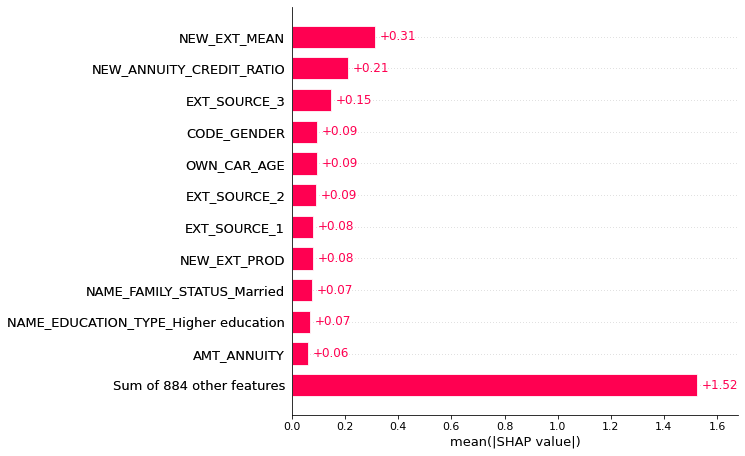

In [113]:
shap.plots.bar(shap_values, max_display=12)

In [114]:
client_index = test_set[test_set['SK_ID_CURR'] == 100005].index.item()

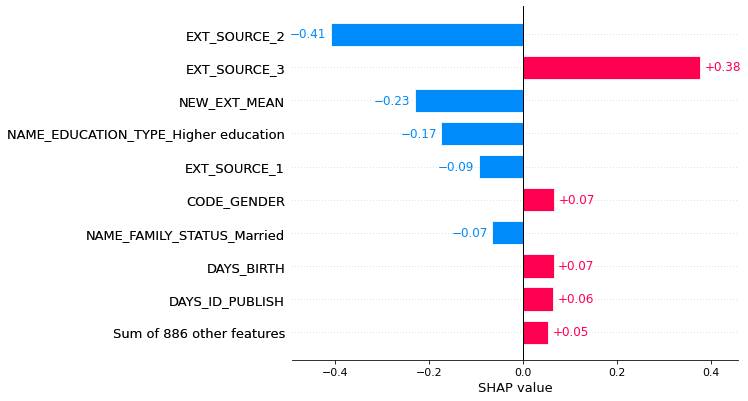

In [115]:
shap.plots.bar(shap_values[0])

In [116]:
explainer = shap.TreeExplainer(best_model)

In [117]:
X_test_0 = X_test.iloc[0]
X_test_0_array = X_test_0.values.reshape(1, -1)

In [119]:
shap_values_0 = explainer.shap_values(X_test_0_array)

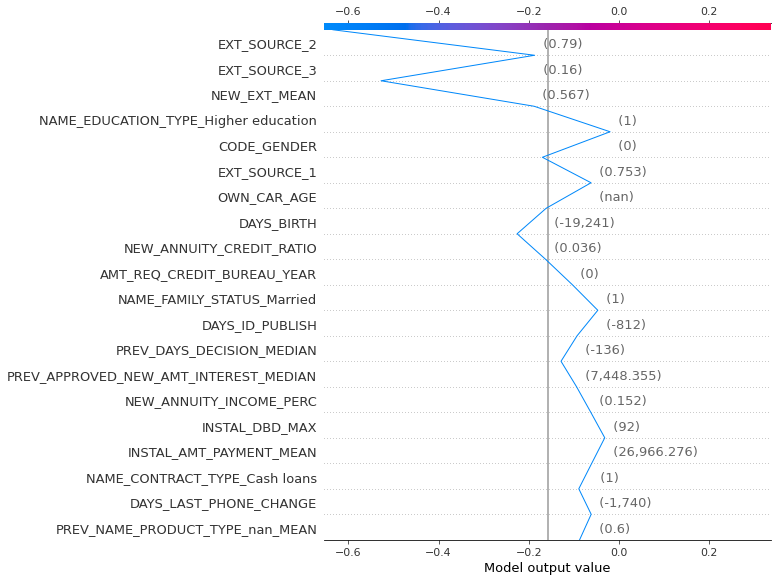

In [120]:
# Decision plot classe négative
shap.decision_plot(explainer.expected_value[1], shap_values_0[1],
                   X_test_0)

Export de application_test pour affichage dashboard

In [121]:
application_test = pd.read_csv('/content/drive/MyDrive/p7/data/application_test.csv')

In [122]:
application_test = reduce_mem_usage(application_test)

-------------------------------------------------------------------------------
Memory usage du dataframe: 45.00 MB
Memory usage après optimization: 14.60 MB
Diminution de 67.6%
-------------------------------------------------------------------------------


In [123]:
filename =  '/content/drive/MyDrive/p7/pickle/application_test.pickle'
outfile = open(filename,'wb')
pickle.dump(application_test, outfile)
outfile.close()